# Co nam daje zastosowanie mapy?

Głównym tematem zadania było zastąpienie list zwierząt i traw mapami. Mapy miały być indeksowane po pozycjach zwierząt, co oznacza, że deklaracja takiej przykładowej mapy wyglądała następujaco: `Map<Vector2d, Animal>`. Używanie pozycji jako kluczy w mapie pozwala przede wszyskim na wydajne wyszukiwanie obiektów po pozycji. Jeśli nasza mapa to konkretnie `HashMap`, wszelkie wywołania `get(position)`, `contains(position)` czy `remove(position)` działają ze złożonością O(1), czyli otrzymujemy odpowiedź niemal od razu. 

Częstym błędem było tutaj zupełnie nadmiarowe przeszukiwanie mapy pętlą:
```java
    public Object objectAt(Vector2d position) {
        for (Vector2d animalPos : animals.keySet()) {
            if (animalPos.equals(position)){
                return animals.get(animalPos);
            }
        }
        return null;
    }
```
Skoro wiemy jakiej pozycji szukamy to możemy powyższy kod zapisać tak:
```java
    public Object objectAt(Vector2d position) {
        return animals.get(position);
    }
```
Nie tylko rozwiązanie jest krótsze niż wcześniej, ale przede wszystkim znacznie wydajniejsze - przeszukiwanie całej kolekcji pętlą ma złożoność rzędu O(N)!

**Uwaga**: część osób dodatkowo przed wykonaniem `get(key)` wywołała sprawdzenie `containsKey(key)` - to nie jest zła intuicja, ale w tym przypadku nie musimy tak robić. Jeśli pod kluczem `key` nie ma żadnej wartości to metoda `get(key)` zwróci po prostu `null`. Byłboby to znacznie czytelniejsze, gdyby zamiast tego `get()` zwracało `Optional<Value>`, ale niestety Optionale zostały wprowadzone do języka lata po tym, jak wymyślono interfejs `Map`. Jeśli komuś się to nie podoba to znów bardzo słuszna intuicja, w takiej sytuacji tradycyjnie polecam zapoznać się z językiem Kotlin. ;) 

## Iterowanie po mapie

O ile mapy używamy głównie do wydajnego indeksowania danych, tak mimo wszystko iterowanie po całej mapie również się przydaje. Musimy pamiętać, że **mapa formalnie nie jest kolekcją w Javie**, co znaczy że nie realizuje interfejsu `Collection` i nie ma np. metod `add()` czy też iteratora. Nie oznacza to, że nie da się przejść pętlą po mapie - trzeba tylko zauważyć, że tak naprawdę składa się ona z dwóch "legalnych" kolekcji - zbioru kluczy oraz zestawu wartości. Mamy więc trzy sposoby by przejść po mapie:

1. Iterowanie po kluczach: 
```java
 for (Vector2d grassPos : grasses.keySet()){
     upperRight = grassPos.upperRight(upperRight);
 }
```
Metoda `keySet()` zwraca nam w tym przypadku `Set<Vector2d>`, a więc klasyczny zbiór (w naszym przypadku będzie to konkretnie `HashSet`). Zauważmy, że przeszukiwanie takiego zbioru kluczy ma te same zalety, co przeszukiwanie mapy - jest bardzo wydajne. Jeśli z kolei potrzebujemy odwołać się do wartości, zawsze możemy w pętli wywołać `grasses.get(grassPos)`, ponownie nie stracimy tu nic na wydajności.
1. Iterowanie po wartościach:
```java
 for(Animal animal: animals.values()) {
     System.out.println(animal);
 }
```
Wygląda to dość analogicznie do przegądania kluczy, należy tu jednak zauważyć jedną istotną różnicę: metoda `values()` zwraca nam obiekt `Collection<Animal>`. Nie wiemy więc co jest pod spodem - w szczególności, nie możemy zakładać, że jest to `Set`. Ma to znaczenie, jeśli chcielibyśmy przeszukiwać zbiór wartości. Metoda `contains()` w tym przypadku będzie najprawdopobniej musiała przejść po wszystkich elementach, nie można więc stosować tego tak, jak w przypadku zbioru kluczy.
1. Iterowanie po krotkach:
```java
 for (Map.Entry<Vector2d, Grass> grassPos : grasses.entrySet()){
     upperRight = grassPos.getKey().upperRight(upperRight);
 }
```
Możemy również przejśc po wszystkich pozycjach w mapie traktując je jako pary (klucz, wartość). W Javie nie ma dedykowanego typu opisującego krotki, ale często używamy klas, które mają podobne znaczenie do krotki. W tym przypadku jest to `Map.Entry<Vector2d, Grass>`. Na takim obiekcie możemy potem zawołać `getKey()` lub `getValue()`. I tu ponownie zwracam uwagę na typ kolekcji - jak sama nazwa metody `entrySet()` wskazuje, jest to `Set`. 

# Wzorzec Observer

Sam wzorzec omawialiśmy na zajęciach, dla przypomnienia [warto o nim poczytać (polecam tę stronę)](https://refactoring.guru/pl/design-patterns/observer). Przekładając wzorzec na nasz przypadek możemy ziltrustrować tę sytuację następująco:

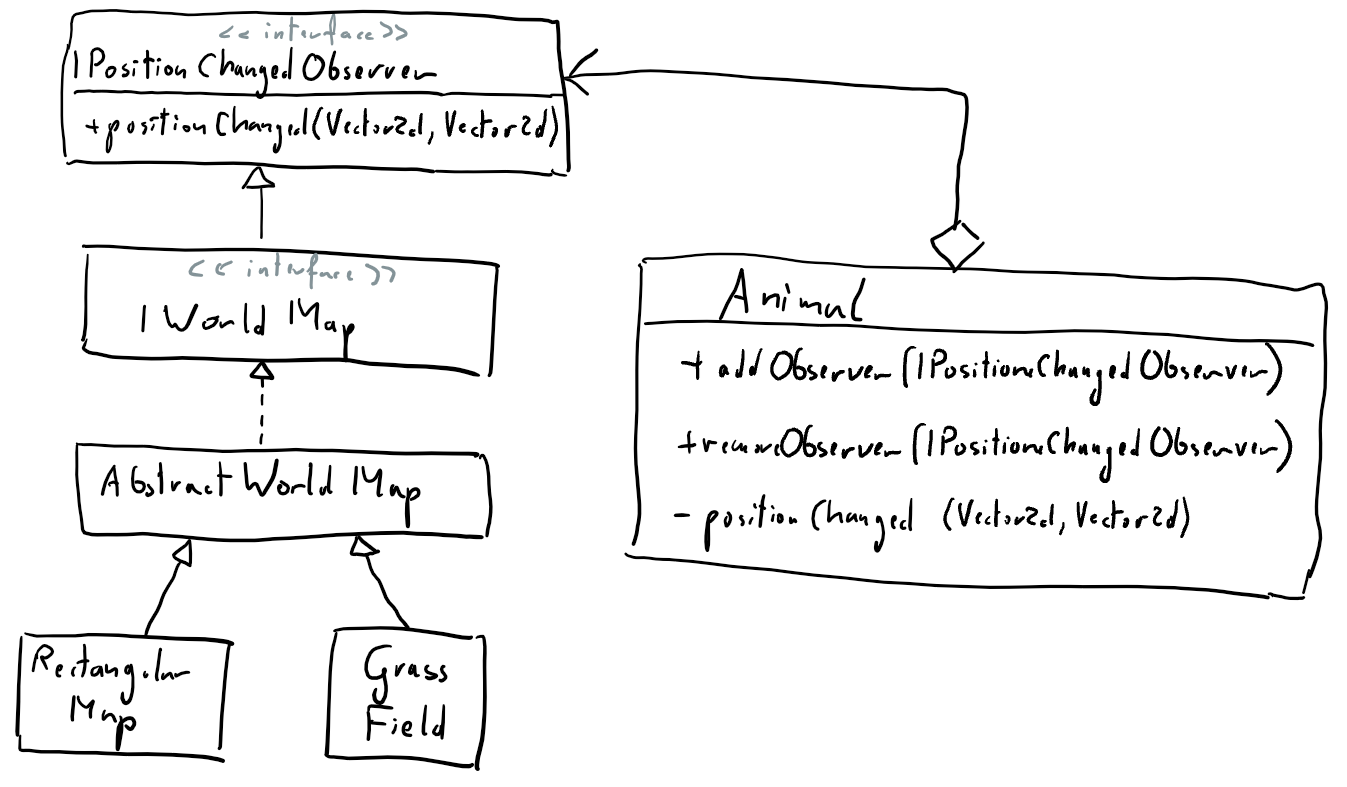

Swoją drogą, tego typu wizualizacja to tzw. diagram klas. Tego typu diagramy tworzymy [wg określonych zasad](https://brasil.cel.agh.edu.pl/~09sbfraczek/diagram-klas%2C1%2C11.html) (określonych przez tzw. UML), co sprawia że można je traktować jako uniwersalny "język" opisu modelu obiektowego. Warto się go nauczyć, żeby swobodnie i szybko wymieniać pomysły przy projektowaniu rozwiązania z innymi osobami. 

Istotne było tutaj umieszczenie wszystkich metod i moment rejestracji mapy jako obserwatora dla zwierzątka. Warto zwrócić tu uwagę na dostępność metod:
```java
public class Animal {
    
    private List<IPositionChangeObserver> observers = new ArrayList<>();
    
    public void addObserver(IPositionChangeObserver observer) {
        observers.add(observer);
    }

    public void removeObserver(IPositionChangeObserver observer) {
        observers.remove(observer);
    }

    
    public void move(MoveDirection direction) {
        ...
        positionChanged(oldPos, newPos);
        ...
    }
    
    private void positionChanged(Vector2d oldPosition, Vector2d newPosition) {
        for (IPositionChangeObserver observer : observers) {
            observer.positionChanged(oldPosition, newPosition);
        }
    }
    
}
```
Metody `addObserver()` / `removeObserver()` powinny być publiczne, bo z założenia każdy może być obserwatorem zwierzątka. Z kolei metoda `positionChanged()` służy do powiadamiania obserwatorów o zdarzeniu, dlatego powinna być prywatna - tylko zwierzę może decydować o tym, kiedy jego pozycja się zmieniła. Pozostałe metody układają się w schemat, który niemal zawsze wygląda tak samo w przypadku tego wzorca projektowego. Różni się zwykle sam interfejs obserwatora i to co przekazujemy mu jako zdarzenie.

Moment rejestracji obserwatora zależy oczywiście od przypadku użycia. U nas można było to zrobić np. w konstruktorze `Animal`, w klasie reprezentującej mapę czy w `SimulationEngine`. Wydaje się, że najsensowniejszym z tych miejsc jest `AbstractWorldMap`, a konkretnie metoda `place(Animal)`, bo to wtedy "rejestrujemy" zwierzę na mapie:
```java
    public boolean place(Animal animal) {
        if (canMoveTo(animal.getPosition())) {
            animals.put(animal.getPosition(), animal);
            animal.addObserver(this);
            return true;
        }
        return false;
    }
```

## Rozszerzanie interfejsów

W przypadku gdy ktoś próbował rejestrować mapę jako obserwatora w innym miejscu, np. w `SimulationEngine` pojawiał się często następujący problem:
```java
public SimulationEngine (MoveDirection[] directions, IWorldMap map, Vector2d[] positions){
    ...
    animal.addObserver((IPositionChangeObserver) map);
    ...
}
```
Działo się tak wtedy, gdy `IPositionChangeObserver` był deklarowany jako interfejs dla klasy `AbstractWorldMap`:
```java
public abstract class AbstractWorldMap implements IWorldMap, IPositionChangeObserver {
    ...
}
```
Oczywiście klasa może implementować dowolnie dużo interfejsów, ale zwróćmy uwagę, że `SimulationEngine` nie operuje na obiekcie typu `AbstractWorldMap` tylko `IWorldMap`, które nie wie nic o `IPositionChangeObserver`. Stąd potrzebne jest rzutowanie, które nie jest ani eleganckie, ani bezpieczne - co jeśli pojawi się inna implementacja `IWorldMap`, która nie będzie obserwatorem?

W tym przypadku ogólnie lepiej byłoby założyć, że **każda** mapa jest obserwatorem więc tak naprawdę to interfejs `IWorldMap` powinien... implementować interfejs obserwatora? O ile implementować nie może (bo nie jest klasą), o tyle **rozszerzyć** (`extends`) już tak:
```java
public interface IWorldMap extends IPositionChangeObserver {
    ...
}
```
Działa to podobnie jak dziedziczenie metod w klasie abstrakcyjnej - interfejs `IWorldMap` nie musi w żaden sposób definiować metody `positionChanged()`, bo jako interfejs z założenia może mieć metody abstrakcyjne. Wystarczy więc sama deklaracja `extends`, a to klasy dziedziczące będą się martwić by dostarczyć implementacji dla `positionChanged()`.


## Klasy anonimowe a wyrażenia lambda

Obserwator to wzorzec, na którym przyjemnie operuje się tzw. klasami anonimowymi albo... wyrażeniami lambda. Wyobraźmy sobie, że mamy dodatkowego obserwatora, który szpieguje zwierzątko i pisze na konsoli informację, za każdym razem gdy się ono poruszy:
```java
    class AnimalSpy implements IPositionChangeObserver {

        @Override
        public void positionChanged(Vector2d oldPosition, Vector2d newPosition) {
           System.out.println("Zwierze zmienilo pozycje: %s --> %s".formatted(oldPosition, newPosition));
        }
    }
```
Możemy takiego obserwatora zarejestrować klasycznie:
```java
animal.addObserver(new AnimalSpy());
```
Wydaje się jednak, że powstało nam stosunkowo dużo kodu jak na tak prosty efekt, który sprowadza się do "wypisz coś jak zwierzątko się poruszy". W dodatku jeśli takiego szpiega będziemy potrzebować tylko w tym jednym miejscu to tworzenie całej klasy z tego powodu wydaje się dość nadmiarowe i ciężkie. Na szczęście można to skrócić, używając wspomnianej klasy anoniomowej:
```java
 animal.addObserver(new IPositionChangeObserver() {
    @Override
    public void positionChanged(Vector2d oldPosition, Vector2d newPosition) {
        System.out.println("Zwierze zmienilo pozycje: %s --> %s".formatted(oldPosition, newPosition));
    }
});
```
Możemy więc utworzyć w miejscu nienazwaną klasę, a następnie stworzyć jej obiekt - tylko na potrzeby tego jednego przypadku.

Brzmi to wszystko nieźle, ale w praktyce składnia klas anonimowych jest, delikatnie mówiąc, nieprzyjemna i mało czytelna. Kiedyś trzeba było się z tym pogodzić i pisać w ten sposób, ale od Javy 8 życie stało się prostsze i beztroskie, ponieważ ten sam efekt można uzyskać tak:
```java
animal.addObserver((oldPosition, newPosition) -> System.out.println("Zwierze zmienilo pozycje: %s -->%s"
                                                                    .formatted(oldPosition, newPosition)));
```
Jest to oczywiście znane już nam wcześniej wyrażenie lambda. Pamiętajmy, że Java jest językiem obiektowym i dość konserwatywnym w tym względzie więc nawet elementy funkcyjne są realizowane obiektowo. Wyrażenia lambda to tak naprawdę jedynie "nakładka" na **klasy anonimowe realizujące interfejs posiadający dokładnie jedną metodę**. Nasz interfejs spełnia ten warunek więc każda metoda, która oczekuje obiektu tego interfejsu może również przyjąć lambdę z dwoma parametrami typu `Vector2d`, która nic nie zwraca. 

Co więcej, w bardzo podobny sposób działają tzw. *method references*, czyli pseudo-referencje na metody. Pseudo, bo podobnie jak wyrażenia lambda to również tylko skrót, *syntax sugar*. Załóżmy, że mamy jeszcze inny obserwatora - np. klasę `Predator`, która posiada metodę `void trackAnimal(Vector2d oldPos, Vector2d newPos)`. Obserwator działałby następująco:

```java
animal.addObserver((oldPosition, newPosition) -> predator.trackAnimal(oldPosition, newPosition));
```
W tej sytuacji nasza lambda jedynie deleguje wywołanie do innej metody, której sygnatura jest identyczna jak `positionChanged()`. Jest to sygnał, że możemy w tym miejscu zastosować method reference:

```java
animal.addObserver(predator::trackAnimal);
```
Tego typu składnię możemy na intuicję czytać tak: "ilekroć zwierzę się ruszy, wywołaj metodę `trackAnimal()`". Wygląda to więc tak jakbyśmy przekazywali w tym miejscu "wskaźnik na funkcję". W rzeczywistości działa to jednak w pełni obiektowo, tak jak wyżej pokazaliśmy.

                
